# Технологии обработки больших данных

## Занятие 5. Машинное обучение в PySpark. Классификация 

1. Понятие энтропии Шеннона и поставновка задачи классификации
2. Классификация с помощью решающих деревьев
3. Домашнее задание 
  
**Рекомендованная литература:** 
- [machinelearning.ru](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F)
- [Open Data Science Mlcourse ч.3](https://habr.com/ru/company/ods/blog/322534/).

## Установка pyspark в изолированой среде venv / conda env !

! pip install pyspark

In [1]:
import pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

22/04/21 13:18:05 WARN Utils: Your hostname, calc resolves to a loopback address: 127.0.1.1; using 192.168.122.1 instead (on interface virbr0)
22/04/21 13:18:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/21 13:18:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 1. Понятие энтропии Шеннона и поставновка задачи классификации

In [55]:
import numpy as np
import matplotlib.pyplot as plt

Пусть имеется выборка случайных чисел с равномерным распределением

In [37]:
y = np.random.randint(0, 2, size=(20))
print(y)

[0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0]


**Этнтропия Шеннона** - мера упорядоченности выборки (системы).  

$$\Large S = - \sum_{i=0..N} p_i log_2 p_i$$

In [50]:
def entropy(y):
    unique, counts = np.unique(y, return_counts=True)
    N = y.size if type(y) == np.ndarray else len(y)
    p = counts / N
    log_p = np.log(p)
    print(f'p = {p}, log_p = {log_p}')
    S = - np.sum(p*log_p)
    return S

In [38]:
entropy(y)

p = [0.65 0.35], log_p = [-0.43078292 -1.04982212]


0.6474466390346325

Для полностью упорядоченной системы энтропия равна нулю

In [25]:
entropy(np.ones(20))

p = [1.], log_p = [0.]


-0.0

Чем больше возможных значений случайной величины, тем выше энтропия

In [46]:
y = np.random.randint(0, 11, size=(20))
print(y)

[ 2  4  2  3  9 10  3  6 10  0 10  3  0  8  2  1  7  7  1  5]


In [45]:
entropy(y)

p = [0.08 0.06 0.12 0.06 0.05 0.09 0.07 0.09 0.11 0.15 0.12], log_p = [-2.52572864 -2.81341072 -2.12026354 -2.81341072 -2.99573227 -2.40794561
 -2.65926004 -2.40794561 -2.20727491 -1.89711998 -2.12026354]


2.3452640902479693

Пусть `y` не просто случайная величина, а функция от индекса `i` 

In [47]:
y = np.zeros(20)
y[:10] = 1
print(y)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Энтропия по-прежнему не равна 0, т.е. система не упорядочена

In [48]:
entropy(y)

p = [0.5 0.5], log_p = [-0.69314718 -0.69314718]


0.6931471805599453

Однако, применив правило для разделения выборки на две части `i < 10`, получим две полностью упорядоченные выборки с нулевой энтропией

In [53]:
y1, y2 = [], []

for i in range(len(y)):
    if i < 10:
        y1.append(y[i])
    else:
        y2.append(y[i])
        
print(entropy(y1), entropy(y2))

p = [1.], log_p = [0.]
p = [1.], log_p = [0.]
-0.0 -0.0


В том случае, если `y` зависит от нескольких переменных, суть задачи не меняется: нужно найти такое правило, которое позволит разделить неупорядоченную выборку на несколько более упорядоченных.

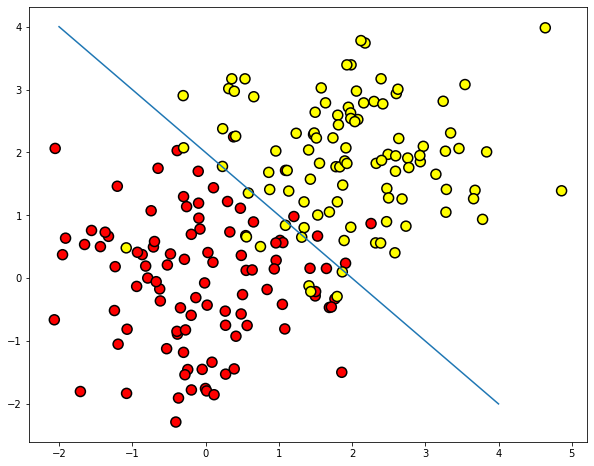

In [56]:
# первый класс
np.random.seed(7)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1));

### 2. Классификация с помощью решающих деревьев

**Columns**  

Age - возраст (numeric)  
Sex - пол (text: male, female)  
Job - уровень рабочей квалификации (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)  
Housing - жилье (text: own, rent, or free)  
Saving accounts - накопления (text - little, moderate, quite rich, rich)  
Checking account - средние траты (numeric, in DM - Deutsch Mark)  
Credit amount - размер кредита (numeric, in DM)  
Duration - срок кредита (numeric, in month)  
Purpose - цель кредита (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [2]:
DATA_PATH = 'sample_data/credit_data.csv'

SCHEMA = "id INT, Age INT, Sex STRING, Job INT, Housing STRING, Saving_accounts STRING, \
Checking_account STRING, Credit_amount INT, Duration INT, Purpose STRING"

df = spark.read.csv(DATA_PATH, schema=SCHEMA, header=True)
type(df)

pyspark.sql.dataframe.DataFrame

## 3. Домашнее задание 